In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Code to Handle Missing Embeddings and Filter DDI Labels

In [ ]:
import torch
import pandas as pd

# File paths
cleaned_ddi_labels_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_balanced_ddi_labels.csv"
cleaned_drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_updated_drug_targets.csv"
drug_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_embeddings.pt"
filtered_ddi_labels_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/filtered_balanced_ddi_labels.csv"
missing_drugs_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_drugs.csv"

# Load data
ddi_labels_df = pd.read_csv(cleaned_ddi_labels_file)
drug_embeddings = torch.load(drug_embeddings_file)

# Step 1: Identify Missing Drugs
missing_drugs = set()

for _, row in ddi_labels_df.iterrows():
    drug1_id = row['drug1']
    drug2_id = row['drug2']
    if drug1_id not in drug_embeddings or drug2_id not in drug_embeddings:
        missing_drugs.update([drug1_id, drug2_id])

print(f"Total Missing Drugs: {len(missing_drugs)}")
print("Sample Missing Drugs:", list(missing_drugs)[:10])

# Save missing drugs to a file
pd.DataFrame({"missing_drugs": list(missing_drugs)}).to_csv(missing_drugs_file, index=False)
print(f"Missing drug IDs saved to {missing_drugs_file}")

# Step 2: Analyze Missing Drugs in Drug Targets File
drug_targets_df = pd.read_csv(cleaned_drug_targets_file)
missing_drugs_in_targets = drug_targets_df[drug_targets_df['drug_id'].isin(missing_drugs)]
print(f"Missing drugs found in drug targets: {len(missing_drugs_in_targets)}")

# Step 3: Filter Out Pairs with Missing Drugs
valid_pairs = ddi_labels_df[
    ddi_labels_df['drug1'].isin(drug_embeddings.keys()) &
    ddi_labels_df['drug2'].isin(drug_embeddings.keys())
]

print(f"Total valid pairs after filtering: {len(valid_pairs)}")

# Save the filtered DDI labels
valid_pairs.to_csv(filtered_ddi_labels_file, index=False)
print(f"Filtered DDI labels saved to {filtered_ddi_labels_file}")


<ipython-input-1-52df79c2d281>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  drug_embeddings = torch.load(drug_embeddings_file)


Total Missing Drugs: 936
Sample Missing Drugs: ['DB00184', 'DB02938', 'DB01897', 'DB03018', 'DB00824', 'DB02887', 'DB00534', 'DB06729', 'DB12010', 'DB04518']
Missing drug IDs saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_drugs.csv
Missing drugs found in drug targets: 2836
Total valid pairs after filtering: 895684
Filtered DDI labels saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/filtered_balanced_ddi_labels.csv


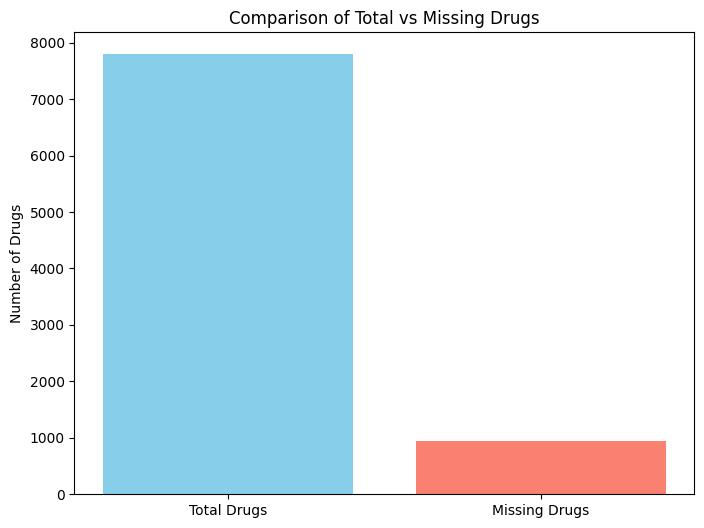

In [ ]:
import matplotlib.pyplot as plt

# Data
total_drugs = len(drug_embeddings)
missing_drugs = len(missing_drugs)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(["Total Drugs", "Missing Drugs"], [total_drugs, missing_drugs], color=["skyblue", "salmon"])
plt.ylabel("Number of Drugs")
plt.title("Comparison of Total vs Missing Drugs")
plt.show()


### Code to Process Missing Drugs

In [ ]:
import pandas as pd
import torch
from tqdm import tqdm

# File paths
missing_drugs_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_drugs.csv"
drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_updated_drug_targets.csv"
protein_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/protein_embeddings.pt"
drug_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_embeddings.pt"
updated_drug_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_drug_embeddings.pt"

# Load files
missing_drugs = pd.read_csv(missing_drugs_file)["missing_drugs"].tolist()
drug_targets_df = pd.read_csv(drug_targets_file)
protein_embeddings = torch.load(protein_embeddings_file)
drug_embeddings = torch.load(drug_embeddings_file)

# Process missing drugs
new_drug_embeddings = {}
for drug_id in tqdm(missing_drugs, desc="Processing Missing Drugs"):
    # Get the target proteins for the drug
    target_proteins = drug_targets_df[drug_targets_df["drug_id"] == drug_id]["protein_id"].tolist()

    # Check if all target protein embeddings are available
    available_proteins = [protein_id for protein_id in target_proteins if protein_id in protein_embeddings]

    if not available_proteins:
        print(f"Warning: No valid protein embeddings for drug {drug_id}")
        continue

    # Regenerate drug embedding by averaging target protein embeddings
    protein_embeds = [protein_embeddings[protein_id] for protein_id in available_proteins]
    drug_embedding = torch.mean(torch.stack(protein_embeds), dim=0)

    # Add to new drug embeddings
    new_drug_embeddings[drug_id] = drug_embedding

print(f"New drug embeddings generated: {len(new_drug_embeddings)}")

# Update drug embeddings
drug_embeddings.update(new_drug_embeddings)

# Save updated drug embeddings
torch.save(drug_embeddings, updated_drug_embeddings_file)
print(f"Updated drug embeddings saved to {updated_drug_embeddings_file}")


<ipython-input-3-0d4831c0a82b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  protein_embeddings = torch.load(protein_embeddings_file)
<ipython-input-3-0d4831c0a82b>:16: 

Processing Missing Drugs:  24%|██▍       | 223/936 [00:00<00:01, 359.63it/s]

Processing Missing Drugs:  66%|██████▌   | 614/936 [00:01<00:00, 359.26it/s]

Processing Missing Drugs:  86%|████████▌ | 803/936 [00:02<00:00, 368.89it/s]

Processing Missing Drugs: 100%|██████████| 936/936 [00:02<00:00, 354.03it/s]

New drug embeddings generated: 928


Updated drug embeddings saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_drug_embeddings.pt


In [ ]:
!pip install biopython

In [ ]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
import requests
import torch
import pandas as pd

# Function to fetch a sequence from UniProt
def fetch_sequence_from_uniprot(protein_id):
    url = f"https://www.uniprot.org/uniprot/{protein_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        return "".join(response.text.split("\n")[1:])
    return None

# File paths
fasta_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_cleaned_protein_sequences.fasta"
drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_updated_drug_targets.csv"
protein_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/protein_embeddings.pt"

# Load protein embeddings
protein_embeddings = torch.load(protein_embeddings_file)

# Load drug targets file
drug_targets_df = pd.read_csv(drug_targets_file)

# Problematic drugs
problematic_drugs = ["DB02145", "DB02302", "DB03335", "DB01701", "DB04320", "DB03733", "DB13900", "DB02793"]
problematic_mapping = drug_targets_df[drug_targets_df["drug_id"].isin(problematic_drugs)]

# Check for missing proteins
missing_protein_details = []
for drug_id in problematic_mapping["drug_id"].unique():
    proteins = problematic_mapping[problematic_mapping["drug_id"] == drug_id]["protein_id"].tolist()
    missing_proteins = [pid for pid in proteins if pid not in protein_embeddings]
    if missing_proteins:
        missing_protein_details.append({"drug_id": drug_id, "missing_proteins": missing_proteins})

# Debugging output
print("Missing protein details:", missing_protein_details)

if not missing_protein_details:
    print("No missing proteins detected. All proteins are already present in the embeddings.")
else:
    # Fetch missing proteins
    for detail in missing_protein_details:
        for protein_id in detail["missing_proteins"]:
            sequence = fetch_sequence_from_uniprot(protein_id)
            if sequence:
                with open(fasta_file, "a") as fasta_out:
                    record = SeqRecord(Seq(sequence), id=protein_id, description="")
                    SeqIO.write(record, fasta_out, "fasta")
                print(f"Added sequence for protein: {protein_id}")
            else:
                print(f"Failed to fetch protein: {protein_id}")


<ipython-input-14-0b663e44c25c>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  protein_embeddings = torch.load(protein_embeddings_file)


Missing protein details: []
No missing proteins detected. All proteins are already present in the embeddings.


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm

# Paths
ddi_labels_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/filtered_balanced_ddi_labels.csv"
drug_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_drug_embeddings.pt"
output_feature_vectors_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features.pt"

# Parameters
batch_size = 100000  # Process 100,000 rows at a time
save_interval = 50000  # Save progress every 50,000 rows

# Load data
print("Loading drug embeddings...")
drug_embeddings = torch.load(drug_embeddings_file)

print("Loading DDI labels...")
ddi_labels_df = pd.read_csv(ddi_labels_file)

# Initialize storage for feature vectors and labels
feature_vectors = []
labels = []
batch_counter = 0

# Generate feature vectors in batches
print("Generating drug-pair feature vectors in batches...")
for idx, row in tqdm(ddi_labels_df.iterrows(), total=len(ddi_labels_df)):
    drug1 = row['drug1']
    drug2 = row['drug2']
    label = row['label']

    # Retrieve embeddings for both drugs
    if drug1 in drug_embeddings and drug2 in drug_embeddings:
        embedding1 = drug_embeddings[drug1]
        embedding2 = drug_embeddings[drug2]

        # Concatenate embeddings to create the feature vector
        feature_vector = torch.cat((embedding1, embedding2), dim=0)
        feature_vectors.append(feature_vector)
        labels.append(label)
    else:
        print(f"Warning: Missing embedding for {drug1} or {drug2}")

    # Save batch to disk at intervals
    if (idx + 1) % save_interval == 0 or (idx + 1) == len(ddi_labels_df):
        print(f"Saving batch {batch_counter + 1}...")
        batch_output_file = output_feature_vectors_file.replace(".pt", f"_batch{batch_counter + 1}.pt")
        torch.save({"features": feature_vectors, "labels": labels}, batch_output_file)
        print(f"Batch {batch_counter + 1} saved to {batch_output_file}")
        # Reset storage for the next batch
        feature_vectors = []
        labels = []
        batch_counter += 1

print("All batches processed and saved.")


Loading drug embeddings...


<ipython-input-1-b6416b3abc61>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  drug_embeddings = torch.load(drug_embeddings_file)


Loading DDI labels...
Generating drug-pair feature vectors in batches...


  6%|▌         | 49985/895684 [00:06<01:45, 7994.66it/s]

Saving batch 1...


  6%|▌         | 51684/895684 [00:19<46:13, 304.28it/s]  

Batch 1 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch1.pt


 11%|█         | 99111/895684 [00:24<01:11, 11098.32it/s]

Saving batch 2...


 11%|█         | 100424/895684 [00:41<55:25, 239.17it/s]  

Batch 2 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch2.pt


 17%|█▋        | 149365/895684 [00:47<01:11, 10497.00it/s]

Saving batch 3...


 17%|█▋        | 150841/895684 [01:02<41:28, 299.35it/s]

Batch 3 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch3.pt


 22%|██▏       | 199242/895684 [01:07<01:06, 10547.16it/s]

Saving batch 4...


 23%|██▎       | 201752/895684 [01:22<27:08, 426.05it/s]

Batch 4 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch4.pt


 28%|██▊       | 249315/895684 [01:27<01:31, 7098.68it/s]

Saving batch 5...


 28%|██▊       | 250533/895684 [01:41<46:54, 229.19it/s]  

Batch 5 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch5.pt


 33%|███▎      | 299627/895684 [01:49<02:40, 3714.34it/s]

Saving batch 6...


 34%|███▎      | 301791/895684 [02:02<30:25, 325.41it/s]

Batch 6 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch6.pt


 39%|███▉      | 349526/895684 [02:07<00:51, 10637.83it/s]

Saving batch 7...


 39%|███▉      | 350320/895684 [02:24<42:58, 211.48it/s]

Batch 7 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch7.pt


 45%|████▍     | 399918/895684 [02:31<01:24, 5844.43it/s]

Saving batch 8...


 45%|████▍     | 400560/895684 [02:45<47:17, 174.48it/s] 

Batch 8 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch8.pt


 50%|█████     | 449795/895684 [02:50<00:44, 9926.22it/s]

Saving batch 9...


 50%|█████     | 451998/895684 [03:05<21:09, 349.37it/s]

Batch 9 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch9.pt


 56%|█████▌    | 499739/895684 [03:12<02:13, 2962.80it/s]

Saving batch 10...


 56%|█████▌    | 500850/895684 [03:25<31:51, 206.55it/s]

Batch 10 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch10.pt


 61%|██████▏   | 549237/895684 [03:31<00:32, 10814.02it/s]

Saving batch 11...


 62%|██████▏   | 551410/895684 [03:44<14:25, 397.92it/s]

Batch 11 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch11.pt


 67%|██████▋   | 599719/895684 [03:50<00:27, 10901.13it/s]

Saving batch 12...


 67%|██████▋   | 601008/895684 [04:05<17:13, 285.11it/s]

Batch 12 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch12.pt


 73%|███████▎  | 649553/895684 [04:11<00:23, 10287.35it/s]

Saving batch 13...


 73%|███████▎  | 650595/895684 [04:25<15:42, 259.91it/s]  

Batch 13 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch13.pt


 78%|███████▊  | 699342/895684 [04:31<00:17, 11121.52it/s]

Saving batch 14...


 78%|███████▊  | 701279/895684 [04:45<09:16, 349.61it/s]

Batch 14 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch14.pt


 84%|████████▎ | 749672/895684 [04:51<00:18, 7860.51it/s]

Saving batch 15...


 84%|████████▍ | 750886/895684 [05:06<10:27, 230.68it/s]

Batch 15 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch15.pt


 89%|████████▉ | 799085/895684 [05:12<00:13, 7239.94it/s] 

Saving batch 16...


 89%|████████▉ | 800909/895684 [05:27<05:07, 308.58it/s]

Batch 16 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch16.pt


 95%|█████████▍| 849338/895684 [05:33<00:04, 10830.87it/s]

Saving batch 17...


 95%|█████████▌| 851086/895684 [05:49<02:34, 289.55it/s]

Batch 17 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch17.pt


100%|█████████▉| 895293/895684 [05:57<00:00, 1963.72it/s]

Saving batch 18...


100%|██████████| 895684/895684 [06:11<00:00, 2410.20it/s]

Batch 18 saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch18.pt
All batches processed and saved.


In [ ]:
import torch
import glob
from tqdm import tqdm

# Directory where batch files are stored
batch_files_pattern = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch*.pt"
output_combined_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_combined.pt"

# Get list of batch files
batch_files = glob.glob(batch_files_pattern)

# Check if batch files are found
if not batch_files:
    raise FileNotFoundError(f"No batch files found matching pattern: {batch_files_pattern}")
else:
    print(f"Found {len(batch_files)} batch files.")

# Initialize combined file with empty lists (if it doesn't already exist)
try:
    combined_data = torch.load(output_combined_file)
    all_features = combined_data.get("features", [])
    all_labels = combined_data.get("labels", [])
    print(f"Loaded existing combined file with {len(all_features)} features.")
except FileNotFoundError:
    print(f"No existing combined file found. Starting fresh.")
    all_features = []
    all_labels = []

# Incrementally combine batches
for batch_file in tqdm(batch_files, desc="Processing batch files"):
    print(f"Processing {batch_file}...")
    try:
        batch_data = torch.load(batch_file)
        all_features.extend(batch_data["features"])
        all_labels.extend(batch_data["labels"])

        # Save intermediate progress to avoid data loss in case of crashes
        torch.save({"features": all_features, "labels": all_labels}, output_combined_file)
    except Exception as e:
        print(f"Error processing {batch_file}: {e}")

# Final save and verification
print(f"Final combined file saved to {output_combined_file}.")
print(f"Total features: {len(all_features)}")
print(f"Total labels: {len(all_labels)}")


<ipython-input-2-4d2ac04fa2bb>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_data = torch.load(output_combined_file)


Found 18 batch files.
No existing combined file found. Starting fresh.


Processing batch files:   0%|          | 0/18 [00:00<?, ?it/s]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch1.pt...


<ipython-input-2-4d2ac04fa2bb>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_data = torch.load(batch_file)
Processing batch files:   6%|▌         | 1/18 [00:21<06:

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch2.pt...


Processing batch files:  11%|█         | 2/18 [00:53<07:23, 27.74s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch3.pt...


Processing batch files:  17%|█▋        | 3/18 [01:54<10:41, 42.74s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch4.pt...


Processing batch files:  22%|██▏       | 4/18 [02:59<12:06, 51.87s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch5.pt...


Processing batch files:  28%|██▊       | 5/18 [04:07<12:27, 57.48s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch6.pt...


Processing batch files:  33%|███▎      | 6/18 [05:29<13:10, 65.88s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch7.pt...


Processing batch files:  39%|███▉      | 7/18 [07:13<14:22, 78.40s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch8.pt...


Processing batch files:  44%|████▍     | 8/18 [09:14<15:17, 91.72s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch9.pt...


Processing batch files:  50%|█████     | 9/18 [11:32<15:56, 106.30s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch10.pt...


Processing batch files:  56%|█████▌    | 10/18 [14:09<16:16, 122.11s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch11.pt...


Processing batch files:  61%|██████    | 11/18 [17:02<16:03, 137.60s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch12.pt...


Processing batch files:  67%|██████▋   | 12/18 [20:16<15:28, 154.72s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch13.pt...


Processing batch files:  72%|███████▏  | 13/18 [24:06<14:47, 177.58s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch14.pt...


Processing batch files:  78%|███████▊  | 14/18 [28:11<13:10, 197.74s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch15.pt...


Processing batch files:  83%|████████▎ | 15/18 [32:49<11:06, 222.07s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch16.pt...


Processing batch files:  89%|████████▉ | 16/18 [38:52<08:48, 264.47s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch17.pt...


Processing batch files:  94%|█████████▍| 17/18 [46:22<05:20, 320.15s/it]

Processing /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_batch18.pt...


Processing batch files: 100%|██████████| 18/18 [55:25<00:00, 184.77s/it]

Final combined file saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_combined.pt.
Total features: 895684
Total labels: 895684


In [ ]:
import torch

# Load data
combined_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_combined.pt"
data = torch.load(combined_file)

# Dataset overview
total_pairs = len(data["features"])
label_counts = {0: data["labels"].count(0), 1: data["labels"].count(1)}

print(f"Total Drug Pairs: {total_pairs}")
print(f"Positive Labels: {label_counts[1]} ({(label_counts[1] / total_pairs) * 100:.2f}%)")
print(f"Negative Labels: {label_counts[0]} ({(label_counts[0] / total_pairs) * 100:.2f}%)")


<ipython-input-3-e230ab07a2de>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(combined_file)


Total Drug Pairs: 895684
Positive Labels: 448332 (50.05%)
Negative Labels: 447352 (49.95%)


# Visualization

## Label Distribution

<ipython-input-2-7843ef6882b9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_data = torch.load(combined_file)


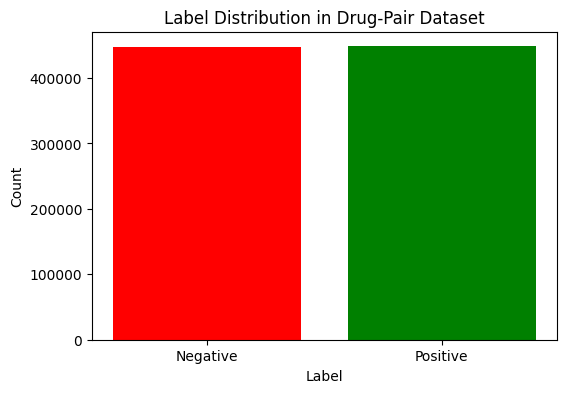

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load combined data
combined_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_pair_features_combined.pt"
combined_data = torch.load(combined_file)
labels = combined_data["labels"]

# Count positive and negative labels
label_counts = {0: labels.count(0), 1: labels.count(1)}

# Bar plot
plt.figure(figsize=(6, 4))
plt.bar(label_counts.keys(), label_counts.values(), color=['red', 'green'], tick_label=["Negative", "Positive"])
plt.title("Label Distribution in Drug-Pair Dataset")
plt.ylabel("Count")
plt.xlabel("Label")
plt.show()


##  Feature Vector Distribution

<ipython-input-3-a79ada0dddc8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_magnitudes = [torch.norm(torch.tensor(f)).item() for f in features]


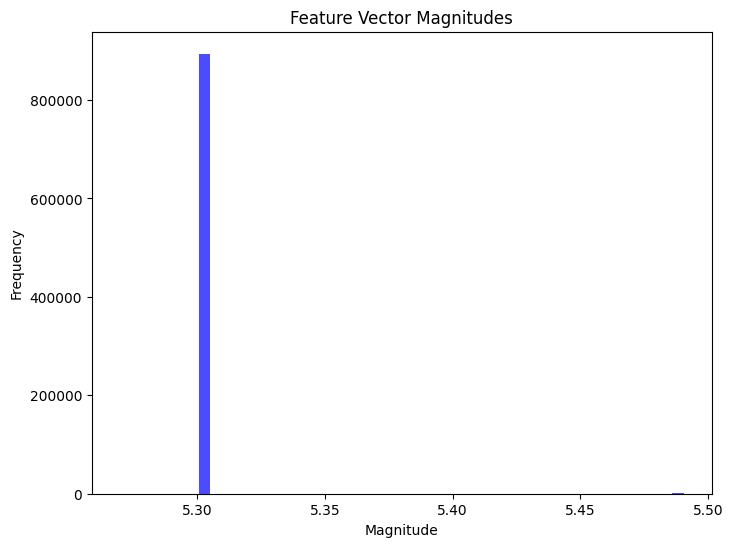

In [ ]:
import numpy as np

# Extract features
features = combined_data["features"]

# Compute magnitude of each feature vector
feature_magnitudes = [torch.norm(torch.tensor(f)).item() for f in features]

# Histogram of magnitudes
plt.figure(figsize=(8, 6))
plt.hist(feature_magnitudes, bins=50, color="blue", alpha=0.7)
plt.title("Feature Vector Magnitudes")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()


### t-SNE Visualization of Feature Vectors

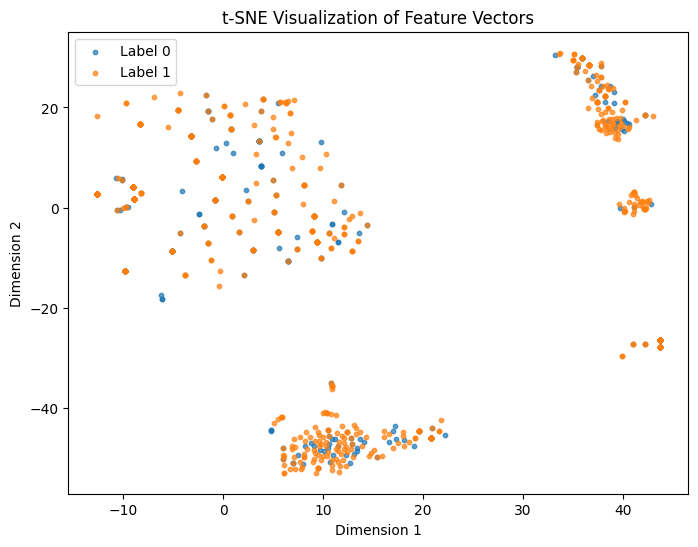

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Sample 2000 data points for t-SNE visualization (for efficiency)
sample_size = 2000
sample_indices = np.random.choice(len(features), sample_size, replace=False)
sample_features = np.array([features[i] for i in sample_indices])
sample_labels = np.array([labels[i] for i in sample_indices])

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(sample_features)

# Scatter plot
plt.figure(figsize=(8, 6))
for label in [0, 1]:
    subset = features_2d[sample_labels == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Label {label}", alpha=0.7, s=10)
plt.title("t-SNE Visualization of Feature Vectors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()



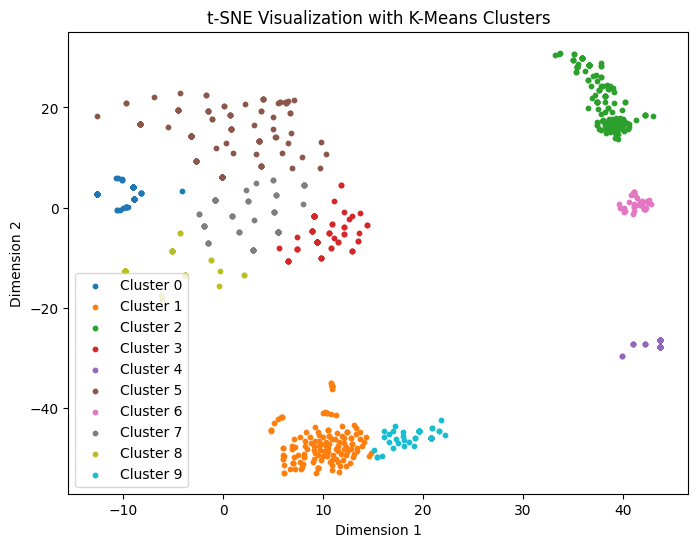

In [ ]:
from sklearn.cluster import KMeans

# Use the t-SNE-transformed features from earlier
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features_2d)

# Scatter plot with cluster labels
plt.figure(figsize=(8, 6))
for cluster_id in range(num_clusters):
    cluster_points = features_2d[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=10)
plt.title("t-SNE Visualization with K-Means Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()
